**Group Memebers:**


- Muhammad Daud Sheikh
- Hamza Luqman
- Okeoghenemarho Obuareghe

In [0]:
%pip install nltk
%pip install pyspellchecker
%pip install mlflow

Python interpreter will be restarted.
  Using cached nltk-3.6.5-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached click-8.0.3-py3-none-any.whl (97 kB)
  Using cached regex-2021.11.10-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-dbff8ef0-eb90-47eb-81dc-e099250ade9b/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached pyspellchecker-0.6.2-py3-none-any.whl (2.7 MB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-dbff8ef0-eb90-47eb-81dc-e099250ade9b/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached mlflow-1.22.0-py3-none-any.whl (15.5 MB)
  Using cached Flask-2.0.2-py3-none-any.whl (95 kB)
  Using cached SQLAlchemy-1.4.28-cp38-cp38-m

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Out[1]: True

In [0]:
display(dbutils.fs.ls("/FileStore/tables/"))

path name size dbfs:/FileStore/tables/Dataset-1.csv Dataset-1.csv 403 dbfs:/FileStore/tables/Dataset-2.csv Dataset-2.csv 403 dbfs:/FileStore/tables/Dataset-3.csv Dataset-3.csv 451 dbfs:/FileStore/tables/Dataset.csv Dataset.csv 272 dbfs:/FileStore/tables/ENSF612_Group19_Notebook_Dec15_isclassified_code.ipynb ENSF612_Group19_Notebook_Dec15_isclassified_code.ipynb 10245133 dbfs:/FileStore/tables/Original_ENSF612.csv Original_ENSF612.csv 6788696 dbfs:/FileStore/tables/Original_Extended_ENSF612.csv Original_Extended_ENSF612.csv 16370841 dbfs:/FileStore/tables/SO_Java.csv SO_Java.csv 114897968 dbfs:/FileStore/tables/SO_Java_Prototype-1.csv SO_Java_Prototype-1.csv 13954768 dbfs:/FileStore/tables/SO_Java_Prototype.csv SO_Java_Prototype.csv 52488945 dbfs:/FileStore/tables/SO_Javascript.csv SO_Javascript.csv 93761324 dbfs:/FileStore/tables/SO_Python.csv SO_Python.csv 87019624 dbfs:/FileStore/tables/Sherlock.txt Sherlock.txt 607430 dbfs:/FileStore/tables/Test_set.csv Test_set.csv 8066237 dbfs:/FileStore/tables/test_dataset.csv test_dataset.csv 9419637

In [0]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import CountVectorizer
 
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import lower, regexp_replace
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from pyspark.sql.functions import col,lit
from pyspark.sql.functions import udf
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from pyspark.sql.types import ArrayType, FloatType, StringType, StructType, StructField, TimestampType, IntegerType

from sklearn.model_selection import train_test_split
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window


from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


# Importing Original and Extended Dataset

In [0]:
# Code Contribution Hamza

Schema = StructType([StructField("Title",StringType(), nullable = False), \
                     StructField("Text", StringType(), nullable = False),\
                     StructField("Subject", StringType(), nullable = False),\
                     StructField("Date", TimestampType(), nullable = False),\
                     StructField("Category", StringType(), nullable = False)])

# File location and type
file_location_Original = "/FileStore/tables/Original_ENSF612.csv"
file_location_Extended = "/FileStore/tables/Original_Extended_ENSF612.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
multi_line = "true"

# The applied options are for CSV files. For other file types, these will be ignored.
original_data = spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header).option("sep", delimiter).option("multiLine",multi_line).option("quote", '"').option("escape", '"').schema(Schema).load(file_location_Original)

extended_data = spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header).option("sep", delimiter).option("multiLine",multi_line).option("quote", '"').option("escape", '"').schema(Schema).load(file_location_Extended)  



#display(original_data)
#display(extended_data)


In [0]:
# Code Contribution Hamza

# Original data
original_df = original_data.withColumn(('Text'), lower('Text')).select("Text", "Category").na.drop()
original_df = original_df.withColumn(('Text'), regexp_replace('Text', '-(?:(?<!\b[0-9]{4}-)|(?![0-9]{2}(?:[0-9]{2})?\b))', " " )).na.drop()

# Extended data
extended_df = extended_data.withColumn(('Text'), lower('Text')).select("Text", "Category").na.drop()
extended_df = extended_df.withColumn(('Text'), regexp_replace('Text', '-(?:(?<!\b[0-9]{4}-)|(?![0-9]{2}(?:[0-9]{2})?\b))', " " )).na.drop()

In [0]:
# Code Contribution Hamza

import pyspark.sql.functions as funcs

# Converting String to Array of String (before pre-processing)
original_data_text_split = original_data.select(split(col("Text")," ").alias("Text"))
original_data_text_split.printSchema()
original_data_text_split.show()

root
 |-- Text: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|                Text|
+--------------------+
|[Former, Presiden...|
|[The, whole, worl...|
|[Donald, Trump, s...|
|[If, Donald, Trum...|
|[President-elect,...|
|[Trump, s, inaugu...|
|[Over, the, years...|
|[Donald, Trump, i...|
|[The, History, ch...|
|[This, House, Rep...|
|[Walmart, has, pu...|
|[, Join, Patrick,...|
|[, Join, Patrick,...|
|[Conservatives, r...|
|[Oh,, Alabama., I...|
|[Republicans, are...|
|[The, whiner-in-c...|
|[On, Tuesday, nig...|
|[Donald, Trump, h...|
|[This, is, despic...|
+--------------------+
only showing top 20 rows



In [0]:
# Code Contribution Hamza

# Getting top words before preprocessing
original_top_word_count = original_data_text_split.withColumn('Text', funcs.explode(funcs.col('Text'))).groupBy('Text').count().sort('count', ascending=False)
original_top_word_count.show()

+-----+-----+
| Text|count|
+-----+-----+
|  the|52101|
|   to|30887|
|   of|25039|
|    a|23313|
|  and|22444|
|     |19838|
|   in|19658|
| that|13416|
|  for|10296|
|   on|10252|
|   is| 9705|
|Trump| 8851|
|    s| 7400|
|   he| 7307|
|  his| 6545|
| with| 6451|
|  has| 6118|
|  was| 5973|
|   as| 5886|
|   by| 5507|
+-----+-----+
only showing top 20 rows



In [0]:
# Code Contribution Daud

# Converting String to Array of String (before pre-processing)
extended_data_text_split = extended_df.select(split(col("Text")," ").alias("Text"))
extended_data_text_split.printSchema()
extended_data_text_split.show()

root
 |-- Text: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|                Text|
+--------------------+
|[former, presiden...|
|[the, whole, worl...|
|[donald, trump, s...|
|[if, donald, trum...|
|[president, elect...|
|[trump, s, inaugu...|
|[over, the, years...|
|[donald, trump, i...|
|[the, history, ch...|
|[this, house, rep...|
|[walmart, has, pu...|
|[, join, patrick,...|
|[, join, patrick,...|
|[conservatives, r...|
|[oh,, alabama., i...|
|[republicans, are...|
|[the, whiner, in,...|
|[on, tuesday, nig...|
|[donald, trump, h...|
|[this, is, despic...|
+--------------------+
only showing top 20 rows



In [0]:
# Code Contribution Hamza

extended_top_word_count = extended_data_text_split.withColumn('Text', funcs.explode(funcs.col('Text'))).groupBy('Text').count().sort('count', ascending=False)
extended_top_word_count.show()

+-----+-----+
| Text|count|
+-----+-----+
|  the|84502|
|   to|46433|
|   of|37697|
|    a|36082|
|     |35143|
|  and|34549|
|   in|31341|
| that|20852|
|  for|15799|
|   on|15608|
|   is|14908|
|trump|13200|
|   he|12966|
|    s|11466|
|  his|10013|
| with| 9836|
|   as| 9438|
|  has| 8991|
|  was| 8943|
|   it| 8815|
+-----+-----+
only showing top 20 rows



# Preprocessing

In [0]:
# Defining Toekenize, stop word removal and noise removal functions
 
  
# Code Contribution Hamza

@udf("String")
def sentence_tokenize(text):  # sentence tokenizer
  from nltk.tokenize import sent_tokenize
  sent = sent_tokenize(text)
  return sent
 
 
@udf("String")
def word_tokenizer(text):  # word tokenizer
  words = []
  for sentence in text:
    word_token = word_tokenize(sentence)
    for word in word_token:
      words.append(word)
  return words
 
 
 
 
@udf("String")
def stop_words(text):  # stop word removal
  words = []
  stop_en = stopwords.words('english')
  for word in text:
    if word not in stop_en:
      words.append(word)
  return words
 
 # Code Contribution Daud
 
@udf("String")
def noise_filter(text): # noise filtering
  words = []
  filter_words = ['id', 'im', '!', '$', '.', "\\" , "/" , '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '20', '(', ')', '[' , ']', ';', ':', '#', '*', 
            '~', '_', '@', '?', '{', '}', '%', ',', '21st']  # defining noise

  for word in text:
    if word not in filter_words:
      words.append(word)
  return words

In [0]:
# Code Contribution Daud

#@udf("String")
@udf(returnType = ArrayType(StringType()))
def stemming(text):
  #ps = PorterStemmer()
  snowball = SnowballStemmer(language = 'english')
  words = []
  stem_words = []
  for word in text:
      words.append(word)
 
  
  for word in words:
    the_word = snowball.stem(word)
    stem_words.append(the_word)
  return stem_words

In [0]:
# Code Contribution Hamza

# tokenizing, stop word removal and noise filtering on original data

clean_df_original= original_df.withColumn('Text', sentence_tokenize('Text'))  # sentence tokenize
clean_df_original = clean_df_original.withColumn('Text', word_tokenizer('Text'))  # word tokenize
clean_df_original = clean_df_original.withColumn('Text', stop_words('Text'))  # stop word removal 
clean_df_original = clean_df_original.withColumn('Text', noise_filter('Text'))  # noise removal

In [0]:
# Code Contribution Hamza

# tokenizing, stop word removal and noise filtering on extended data

clean_df_extended = extended_df.withColumn('Text', sentence_tokenize('Text'))  # sentence tokenize
clean_df_extended = clean_df_extended.withColumn('Text', word_tokenizer('Text'))  # word tokenize
clean_df_extended = clean_df_extended.withColumn('Text', stop_words('Text'))  # stop word removal 
clean_df_extended = clean_df_extended.withColumn('Text', noise_filter('Text'))  # noise removal


In [0]:
# Code Contribution Hamza

# Stemming original data
data_original = clean_df_original.withColumn("Text", stemming("Text").alias("Text"))  # Stemming



In [0]:
# Code Contribution Hamza

# Stemming extended data
data_extended = clean_df_extended.withColumn("Text", stemming("Text").alias("Text")) # Stemming

In [0]:
display(data_original)

Text Category List(former, presid, georg, h., w., bush, can, teach, donald, trump, a, thing, or, two, about, handl, conflict, of, interest.a, januari, 20th, approach, ,, donald, trump, is, appar, pois, to, violat, the, constitut, the, moment, he, finish, recit, the, oath, of, offic, becaus, he, has, yet, to, proper, elimin, the, conflict, of, interest, between, himself, and, his, famili, business.publ, offici, are, not, allow, to, use, their, offic, to, to, influenc, polici, that, would, increas, profit, of, a, compani, they, have, a, person, stake, in, ., by, not, put, his, asset, ,, includ, the, trump, organ, and, ani, stock, he, own, ,, into, a, blind, trust, or, sell, them, off, ,, trump, is, violat, the, the, emolu, claus, and, break, decad, of, precedent.th, most, exampl, is, when, jimmi, carter, sold, the, peanut, busi, he, built, from, the, ground, up, to, avoid, conflict, of, interest, ., of, cours, ,, republican, initi, a, seri, of, witch, hunt, against, carter, s, busi, anyway, in, a, desper, effort, to, find, a, scandal, ., today, ,, republican, don, t, care, if, trump, continu, to, own, his, busi, ,, even, though, he, is, alreadi, use, the, presid, to, make, busi, deal, and, bring, in, profits.inde, ,, when, ivanka, trump, sat, in, dure, a, meet, between, her, father, and, the, japanes, prime, minist, ,, her, compani, was, in, the, middl, of, work, on, a, deal, with, a, japanes, company.a, newsweek, explain, ,, at, the, same, time, ,, offici, with, her, cloth, compani, were, work, on, a, licens, agreement, with, sanei, intern, ., the, largest, sharehold, of, sanei, s, parent, compani, is, the, develop, bank, of, japan, ,, which, is, wholli, own, by, the, japanes, govern, head, by, abe.trump, has, also, talk, to, the, presid, of, taiwan, and, the, leader, of, argentina, ,, where, trump, s, compani, is, tri, to, secur, deal, to, build, hotel, ., clear, ,, trump, is, flagrant, use, the, presid, to, enrich, himself, and, his, company.georg, h.w, ., bush, warn, his, own, famili, not, to, do, this, or, even, make, it, appear, that, they, are, do, it, by, send, each, famili, member, a, letter, in, 1988, in, the, midst, of, the, presidenti, election.th, elder, bush, told, his, famili, that, peopl, are, go, to, tri, to, be, their, friend, but, that, friendship, could, result, in, ask, for, favor, simpli, becaus, they, are, connect, to, the, leader, of, the, free, world, ., if, there, is, a, legitim, inquiri, ,, call, my, offic, ,, bush, wrote, ., it, is, certain, appropri, to, contact, your, own, govern, ,, but, let, s, do, it, through, my, offic, so, no, one, can, accus, ani, of, the, famili, of, tri, to, use, influenc, ., in, other, word, ,, bush, told, his, famili, not, to, call, him, on, their, friend, s, behalf, ., they, have, to, call, his, offic, themselves.bush, knew, all, too, well, that, ,, everi, effort, will, be, made, to, find, some, phone, call, ,, some, inquiri, ,, some, letter, that, can, be, made, to, appear, improp, ., here, s, the, full, letter, via, twitter.pic.twitter.com/60gkf4qiij, eric, lipton, (, @, ericliptonnyt, ), decemb, 21, ,, 2016donald, trump, ,, howev, ,, is, influenc, by, his, busi, and, sinc, his, children, are, deepli, involv, in, the, compani, ,, that, mean, they, ll, have, special, access, to, him, and, will, be, abl, to, curri, favor, such, as, ask, him, to, gut, certain, regul, or, ask, him, to, call, certain, foreign, leader, to, push, through, busi, deals.that, s, a, serious, ethic, violat, that, can, not, be, toler, ., hell, ,, eric, trump, has, alreadi, been, bust, tri, to, sell, access, to, his, father, in, exchang, for, $, 1, million, donat, to, his, fraudul, chariti, ., so, it, s, pretti, clear, that, there, is, alreadi, a, pay, for, play, scandal, brew, befor, trump, has, even, taken, office.thi, need, to, stop, now, and, the, onli, way, it, will, stop, is, if, trump, sell, his, compani, or, put, it, into, a, blind, trust, ., anyth, less, is, unacceptable.featur, imag, :, wik

In [0]:
display(data_extended)

Text Category List(former, presid, georg, h., w., bush, teach, donald, trump, thing, two, handl, conflict, interest.a, januari, 20th, approach, donald, trump, appar, pois, violat, constitut, moment, finish, recit, oath, offic, yet, proper, elimin, conflict, interest, famili, business.publ, offici, allow, use, offic, influenc, polici, would, increas, profit, compani, person, stake, put, asset, includ, trump, organ, stock, own, blind, trust, sell, trump, violat, emolu, claus, break, decad, precedent.th, exampl, jimmi, carter, sold, peanut, busi, built, ground, avoid, conflict, interest, cours, republican, initi, seri, witch, hunt, carter, busi, anyway, desper, effort, find, scandal, today, republican, care, trump, continu, busi, even, though, alreadi, use, presid, make, busi, deal, bring, profits.inde, ivanka, trump, sat, meet, father, japanes, prime, minist, compani, middl, work, deal, japanes, company.a, newsweek, explain, time, offici, cloth, compani, work, licens, agreement, sanei, intern, largest, sharehold, sanei, parent, compani, develop, bank, japan, wholli, own, japanes, govern, head, abe.trump, also, talk, presid, taiwan, leader, argentina, trump, compani, tri, secur, deal, build, hotel, clear, trump, flagrant, use, presid, enrich, company.georg, h.w, bush, warn, famili, even, make, appear, send, famili, member, letter, 1988, midst, presidenti, election.th, elder, bush, told, famili, peopl, go, tri, friend, friendship, could, result, ask, favor, simpli, connect, leader, free, world, legitim, inquiri, call, offic, bush, wrote, certain, appropri, contact, govern, let, offic, one, accus, famili, tri, use, influenc, word, bush, told, famili, call, friend, behalf, call, offic, themselves.bush, knew, well, everi, effort, made, find, phone, call, inquiri, letter, made, appear, improp, full, letter, via, twitter.pic.twitter.com/60gkf4qiij, eric, lipton, ericliptonnyt, decemb, 21, 2016donald, trump, howev, influenc, busi, sinc, children, deepli, involv, compani, mean, special, access, abl, curri, favor, ask, gut, certain, regul, ask, call, certain, foreign, leader, push, busi, deals.that, serious, ethic, violat, toler, hell, eric, trump, alreadi, bust, tri, sell, access, father, exchang, million, donat, fraudul, chariti, pretti, clear, alreadi, pay, play, scandal, brew, trump, even, taken, office.thi, need, stop, way, stop, trump, sell, compani, put, blind, trust, anyth, less, unacceptable.featur, imag, wikimedia) Fake List(whole, world, laugh, us, kinda, sorta, elect, sinc, opinion, major, american, meaningless, current, elector, system, introduc, keep, slave, own, state, happi, larg, thank, influenc, russian, hacker, direct, putin, fbi, jame, comey, man, offic, frank, idiot.whil, donald, trump, deni, russia, influenc, elect, choos, instead, attack, intellig, agenc, confirm, putin, person, direct, russian, peopl, field, day, fact, manag, elect, someon, stupid, allow, leader, play, like, fiddle.ask, putin, recent, letter, trump, one, spur, trump, say, correct, russia, expert, nina, khrushcheva, told, msnbc, saturday, donald, play, right, putin, hand, moscow, russian, say, look, fool, look, democraci, absolut, said, could, america, lectur, us, develop, institut, human, right, democraci, rhetor, elect, donald, trump, fool, bulli, america, deserv, go, take, advantag, russian, feel, take, shape, letter, vladimir, putin, donald, trump, exchang, potenti, nuclear, armament, whatnot, ask, weigh, whether, trump, would, hinder, investig, cozi, relationship, putin, talent, team, hacker, intellig, analyst, malcolm, nanc, explain, absolut, would, interfer, investig, faster, putin, interf, elect, think, account, regard, russian, hack, dnc, even, violat, entireti, u.s., elector, process, benefit, go, shut, investig, implic, campaign, howev, nina, righ, play, fool, spymast, chief, former, kgb, offic, director, russian, intellig, laugh, us, letter, stroke, donald, trump, excel, letter, like, unit, state, sinc, king, georg, iii, long, trump, man

In [0]:
# Code Contribution Daud

# Converting String to Array of String to get top words count (After preprocessing)
original_post_processed_text_split = clean_df_original.select(split(col("Text"),",").alias("Text"))
original_post_processed_text_split.printSchema()
original_post_processed_text_split.show()

# Getting top word count after pre-processing
original_post_processed_top_words = original_post_processed_text_split.withColumn('Text', funcs.explode(funcs.col('Text'))).groupBy('Text').count().sort('count', ascending=False)
original_post_processed_top_words.show()

root
 |-- Text: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|                Text|
+--------------------+
|[[former,  presid...|
|[[the,  whole,  w...|
|[[donald,  trump,...|
|[[if,  donald,  t...|
|[[president,  ele...|
|[[trump,  s,  ina...|
|[[over,  the,  ye...|
|[[donald,  trump,...|
|[[the,  history, ...|
|[[this,  house,  ...|
|[[walmart,  has, ...|
|[[join,  patrick,...|
|[[join,  patrick,...|
|[[conservatives, ...|
|[[oh,  , ,  alaba...|
|[[republicans,  a...|
|[[the,  whiner,  ...|
|[[on,  tuesday,  ...|
|[[donald,  trump,...|
|[[this,  is,  des...|
+--------------------+
only showing top 20 rows

+------+-----+
|  Text|count|
+------+-----+
|   the|57338|
|      |55011|
|      |55011|
|     .|34200|
|    to|31280|
|    of|25257|
|     a|24474|
|   and|23406|
|    in|21319|
|  that|14678|
|     s|14458|
| trump|12036|
|    on|10797|
|   for|10652|
|    is|10035|
|     ’| 9226|
|    he| 9139|
|  said| 7586|
|    it| 7004|
|  

In [0]:
# Code Contribution Daud

# Converting String to Array of String to get top words count (After preprocessing)
extended_post_processed_text_split = clean_df_extended.select(split(col("Text"),",").alias("Text"))
extended_post_processed_text_split.printSchema()
extended_post_processed_text_split.show()

# Getting top word count after pre-processing
extended_post_processed_top_words = extended_post_processed_text_split.withColumn('Text', funcs.explode(funcs.col('Text'))).groupBy('Text').count().sort('count', ascending=False)
extended_post_processed_top_words.show()

root
 |-- Text: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|                Text|
+--------------------+
|[[former,  presid...|
|[[whole,  world, ...|
|[[donald,  trump,...|
|[[donald,  trump,...|
|[[president,  ele...|
|[[trump,  inaugur...|
|[[years,  america...|
|[[donald,  trump,...|
|[[history,  chann...|
|[[house,  republi...|
|[[walmart,  pulle...|
|[[join,  patrick,...|
|[[join,  patrick,...|
|[[conservatives, ...|
|[[oh,  alabama,  ...|
|[[republicans,  s...|
|[[whiner,  chief,...|
|[[tuesday,  night...|
|[[donald,  trump,...|
|[[despicable,  mo...|
+--------------------+
only showing top 20 rows

+-------------+-----+
|         Text|count|
+-------------+-----+
|        trump|17591|
|            ’|13115|
|         said|10770|
|            “| 9708|
|            ”| 9403|
|      clinton| 7441|
|     election| 5680|
|        would| 5392|
|   republican| 5254|
|         u.s.| 4883|
|    president| 4657|
|     campaign| 4431|
|  

#Original Data ML

In [0]:
# Code Contribution Hamza

X = data_extended.select("Text")
y = data_extended.select("Category")

In [0]:
# Code Contribution Hamza

# Spliting the data into a 80-20 train test split

X_train, X_test = X.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(X_train.count()))
print("Test Dataset Count: " + str(X_test.count()))

Training Dataset Count: 2394
Test Dataset Count: 606


In [0]:
# Code Contribution Hamza

(y_train, y_test) = y.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(y_train.count()))
print("Test Dataset Count: " + str(y_test.count()))

Training Dataset Count: 2394
Test Dataset Count: 606


In [0]:
# Code Contribution Hamza

# since there is no common column between these two dataframes add row_index so that it can be joined
X_train=X_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
y_train=y_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

data_train = X_train.join(y_train, on=["row_index"]).drop("row_index")
data_train.show()

# since there is no common column between these two dataframes add row_index so that it can be joined
X_test=X_test.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
y_test=y_test.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

data_test = X_test.join(y_test, on=["row_index"]).drop("row_index")
data_test.show()

+--------------------+--------+
|                Text|Category|
+--------------------+--------+
|[126, year, endor...|    Fake|
|[14,000, genese, ...|    Fake|
|[14,000, genese, ...|    Fake|
|[18, octob, 2016,...|    Fake|
|[1988, democrat, ...|    Fake|
|[2013, north, car...|    Fake|
|[2016, presidenti...|    Fake|
|[28, day, left, g...|    Fake|
|[74, year, old, w...|    Fake|
|[aboard, air, for...|    Fake|
|[aboard, air, for...|    Fake|
|[aboard, air, for...|    Fake|
|[accord, donald, ...|    Fake|
|[actor, morgan, f...|    Fake|
|[ad, disgust, man...|    Fake|
|[add, one, name, ...|    Fake|
|[aftermath, great...|    Fake|
|[ah, simpson, hil...|    Fake|
|[albani, new, yor...|    Fake|
|[albani, new, yor...|    Fake|
+--------------------+--------+
only showing top 20 rows

+--------------------+--------+
|                Text|Category|
+--------------------+--------+
|[50, call, republ...|    Fake|
|[aboard, air, for...|    Fake|
|[actress, helen, ...|    Fake|
|[addict, info

In [0]:
# Code Contribution Daud

lsvm = LinearSVC(maxIter=5)
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
lr = LogisticRegression(maxIter=100)

# UniGram with TF

In [0]:
# Code Contribution Daud

ngrams = NGram(n = 1, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
 
assembler = VectorAssembler(inputCols = ["TF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Fake is 1, Real is 0


pipeline_lr = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lr])

pipeline_lsvm = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lsvm])

pipeline_dt = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, dt])


paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()
  


crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5) 


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()

crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)


/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)
/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)
/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation.

# UniGram with TF Results

In [0]:
# Code Contribution Hamza

prediction_lr_classA = cvModel_lr.transform(data_test)
prediction_lsvm_classA = cvModel_lsvm.transform(data_test)
prediction_dt_classA = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''
    
paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)  

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")


Linear Regression Grid Search Results: 
0.6437254296842441
[1000, 0.1]
0.6314359873863024
[1000, 0.01]
0.6647393587644046
[5000, 0.1]
0.6698137286977273
[5000, 0.01]
0.6792870913886022
[10000, 0.1]
0.6763658323613795
[10000, 0.01]



LSVM Grid Search Results: 
0.6468466298850968
[1000, 0.1]
0.6451447713769483
[1000, 0.01]
0.6491556485267744
[5000, 0.1]
0.6520966344461225
[5000, 0.01]
0.6658756769500492
[10000, 0.1]
0.6702831036238741
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6536324587167052
[1000, 2]
0.6588234168209693
[1000, 3]
0.6536324587167052
[5000, 2]
0.65982525984578
[5000, 3]
0.6536324587167052
[10000, 2]
0.65982525984578
[10000, 3]





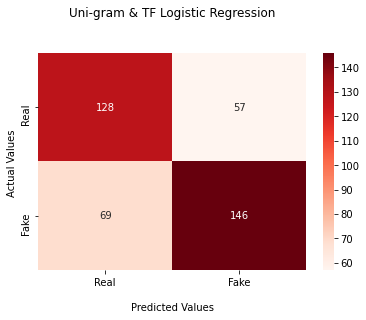

In [0]:
# Code Contribution Hamza

predictionAndLabels_lr_classA = prediction_lr_classA.select(col("label"), col("prediction"))

metrics_lr_classA = MulticlassMetrics(predictionAndLabels_lr_classA.rdd.map(tuple))

classA_lr_metrics = metrics_lr_classA.confusionMatrix().toArray()

ax = sns.heatmap(classA_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


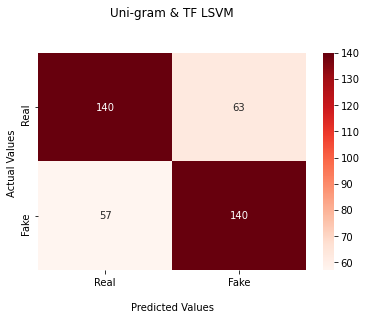

In [0]:
# Code Contribution Hamza

predictionAndLabels_lsvm_classA = prediction_lsvm_classA.select(col("label"), col("prediction"))

metrics_lsvm_classA = MulticlassMetrics(predictionAndLabels_lsvm_classA.rdd.map(tuple))

classA_lsvm_metrics = metrics_lsvm_classA.confusionMatrix().toArray()

ax = sns.heatmap(classA_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [0]:
# Code Contribution Hamza

predictionAndLabels_dt_classA = prediction_dt_classA.select(col("label"), col("prediction"))

metrics_dt_classA = MulticlassMetrics(predictionAndLabels_dt_classA.rdd.map(tuple))

classA_dt_metrics = metrics_dt_classA.confusionMatrix().toArray()

ax = sns.heatmap(classA_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


#### ERROR HAPPENDED AFTERWARDS WHILE COMMENTING CODE ####

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-433056252362248> in <module>
----> 1 predictionAndLabels_dt_classA = prediction_dt_classA.select(col("label"), col("prediction"))
      2 
      3 metrics_dt_classA = MulticlassMetrics(predictionAndLabels_dt_classA.rdd.map(tuple))
      4 
      5 classA_dt_metrics = metrics_dt_classA.confusionMatrix().toArray()

NameError: name 'prediction_dt_classA' is not defined

# Unigram with TF-IDF

In [0]:
# Code Contribution Daud

ngrams = NGram(n = 1, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
  
idf = IDF(inputCol="TF", outputCol="TFIDF")
 
assembler = VectorAssembler(inputCols = ["TFIDF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lr])
pipeline_lsvm = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lsvm])
pipeline_dt = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, dt])

# removed 10000, 1000
# removed 0.5 and 0.01
paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()



crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName='accuracy'),
                          numFolds = 5)  


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()


crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(metricName='accuracy'),
                          numFolds = 5)  


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()


crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(metricName='accuracy'),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)


/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)
/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)
/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation.

# Unigram with TF-IDF Results

In [0]:
# Code Contribution Daud

prediction_lr_classB = cvModel_lr.transform(data_test)
prediction_lsvm_classB = cvModel_lsvm.transform(data_test)
prediction_dt_classB = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6440635594478321
[1000, 0.1]
0.6318656897051933
[1000, 0.01]
0.6647152904328507
[5000, 0.1]
0.6697221917809706
[5000, 0.01]
0.6793713989354797
[10000, 0.1]
0.6764607583130989
[10000, 0.01]



LSVM Grid Search Results: 
0.6458349784157067
[1000, 0.1]
0.6445783033071103
[1000, 0.01]
0.6504132884159866
[5000, 0.1]
0.6492127382872752
[5000, 0.01]
0.6666482940322871
[10000, 0.1]
0.6691698132906598
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6709608534343015
[1000, 2]
0.674609554371304
[1000, 5]
0.6709608534343015
[5000, 2]
0.6835229506954092
[5000, 5]
0.6709608534343015
[10000, 2]
0.6835229506954092
[10000, 5]





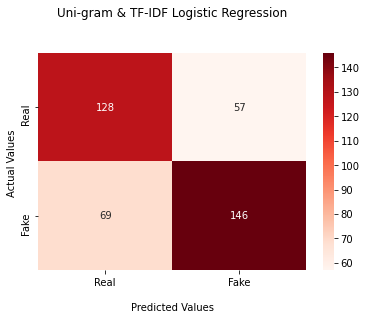

In [0]:
# Code Contribution Daud

predictionAndLabels_lr_classB = prediction_lr_classB.select(col("label"), col("prediction"))

metrics_lr_classB = MulticlassMetrics(predictionAndLabels_lr_classB.rdd.map(tuple))

classB_lr_metrics = metrics_lr_classB.confusionMatrix().toArray()

ax = sns.heatmap(classB_lr_metrics, annot=True, cmap='Reds', fmt='.0f')
#sns.heatmap(table1, cmap='Purples', fmt='.4f')


ax.set_title('Uni-gram & TF-IDF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


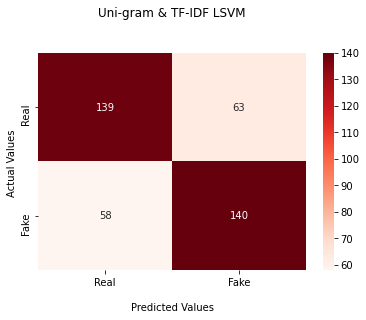

In [0]:
# Code Contribution Daud

predictionAndLabels_lsvm_classB = prediction_lsvm_classB.select(col("label"), col("prediction"))

metrics_lsvm_classB = MulticlassMetrics(predictionAndLabels_lsvm_classB.rdd.map(tuple))

classB_lsvm_metrics = metrics_lsvm_classB.confusionMatrix().toArray()

ax = sns.heatmap(classB_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF-IDF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

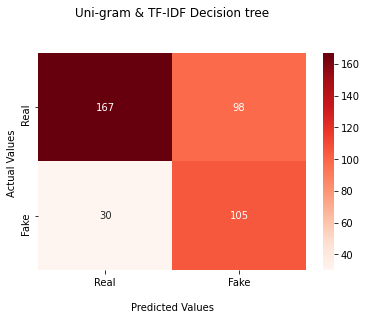

In [0]:
# Code Contribution Daud

predictionAndLabels_dt_classB = prediction_dt_classB.select(col("label"), col("prediction"))

metrics_dt_classB = MulticlassMetrics(predictionAndLabels_dt_classB.rdd.map(tuple))

classB_dt_metrics = metrics_dt_classB.confusionMatrix().toArray()


ax = sns.heatmap(classB_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF-IDF Decision tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Bigram with TF

In [0]:
# Code Contribution Hamza

ngrams = NGram(n = 2, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
 
assembler = VectorAssembler(inputCols = ["TF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lr])
pipeline_lsvm = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lsvm])
pipeline_dt = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, dt])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()



crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()



crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)



/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)


# Bigram with TF Results

In [0]:
# Code Contribution Hamza

prediction_lr_classC = cvModel_lr.transform(data_test)
prediction_lsvm_classC = cvModel_lsvm.transform(data_test)
prediction_dt_classC = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6946442979727517
[1000, 0.1]
0.6819994720888809
[1000, 0.01]
0.6911531317079656
[5000, 0.1]
0.6948924480959806
[5000, 0.01]
0.7054261170532841
[10000, 0.1]
0.6993664321674946
[10000, 0.01]



LSVM Grid Search Results: 
0.6796207711562764
[1000, 0.1]
0.6828722472107852
[1000, 0.01]
0.7003646507259873
[5000, 0.1]
0.7008911926505738
[5000, 0.01]
0.7001724685707003
[10000, 0.1]
0.6995622743957637
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6476701734277719
[1000, 2]
0.6613395450821999
[1000, 5]
0.6476701734277719
[5000, 2]
0.6584533150821625
[5000, 5]
0.6476701734277719
[10000, 2]
0.6658711402078656
[10000, 5]





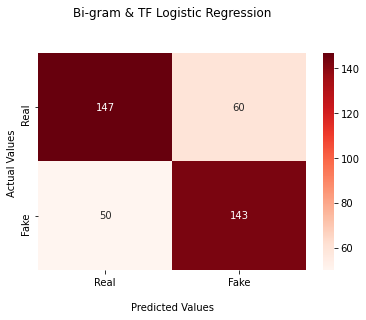

In [0]:
# Code Contribution Hamza

predictionAndLabels_lr_classC = prediction_lr_classC.select(col("label"), col("prediction"))

metrics_lr_classC = MulticlassMetrics(predictionAndLabels_lr_classC.rdd.map(tuple))

classC_lr_metrics = metrics_lr_classC .confusionMatrix().toArray()

ax = sns.heatmap(classC_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


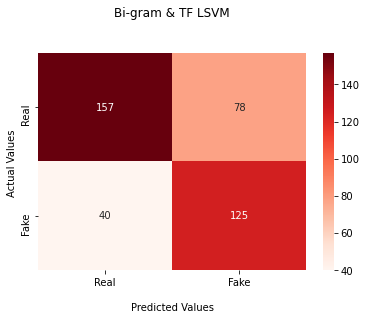

In [0]:
# Code Contribution Hamza

predictionAndLabels_lsvm_classC = prediction_lsvm_classC.select(col("label"), col("prediction"))

metrics_lsvm_classC = MulticlassMetrics(predictionAndLabels_lsvm_classC.rdd.map(tuple))

classC_lsvm_metrics = metrics_lsvm_classC.confusionMatrix().toArray()

ax = sns.heatmap(classC_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

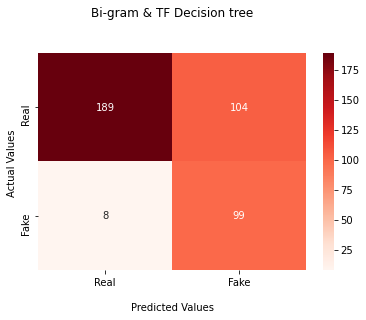

In [0]:
# Code Contribution Hamza

predictionAndLabels_dt_classC = prediction_dt_classC.select(col("label"), col("prediction"))

metrics_dt_classC = MulticlassMetrics(predictionAndLabels_dt_classC.rdd.map(tuple))

classC_dt_metrics = metrics_dt_classC.confusionMatrix().toArray()

ax = sns.heatmap(classC_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF Decision tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Bigram with TF-IDF

In [0]:
# Code Contribution Daud

ngrams = NGram(n = 2, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
  
idf = IDF(inputCol="TF", outputCol="TFIDF")
 
assembler = VectorAssembler(inputCols = ["TFIDF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lr])
pipeline_lsvm = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lsvm])
pipeline_dt = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, dt])


paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()



crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5) 


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()


crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()


crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


# Bigram with TF-IDF Results

In [0]:
# Code Contribution Daud

prediction_lr_classD = cvModel_lr.transform(data_test)
prediction_lsvm_classD = cvModel_lsvm.transform(data_test)
prediction_dt_classD = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6615254422956203
[1000, 0.1]
0.6651300807705376
[1000, 0.01]
0.6585793302327834
[5000, 0.1]
0.660729838990675
[5000, 0.01]
0.6589595812279697
[10000, 0.1]
0.6621102751294059
[10000, 0.01]



LSVM Grid Search Results: 
0.6357415419387434
[1000, 0.1]
0.6355521660232972
[1000, 0.01]
0.6449005021020116
[5000, 0.1]
0.6470241828512389
[5000, 0.01]
0.6531068703106576
[10000, 0.1]
0.6496992311642105
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6487649959703743
[1000, 2]
0.6716304988312252
[1000, 5]
0.6492905144602659
[5000, 2]
0.664308328508634
[5000, 5]
0.6492905144602659
[10000, 2]
0.6694216352820879
[10000, 5]





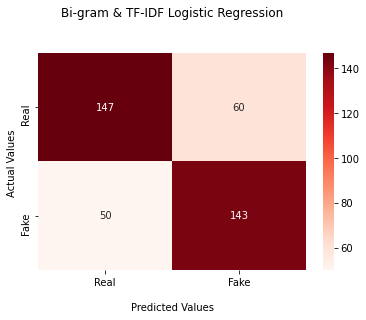

In [0]:
# Code Contribution Daud


predictionAndLabels_lr_classD = prediction_lr_classD.select(col("label"), col("prediction"))

metrics_lr_classD = MulticlassMetrics(predictionAndLabels_lr_classD.rdd.map(tuple))

classD_lr_metrics = metrics_lr_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


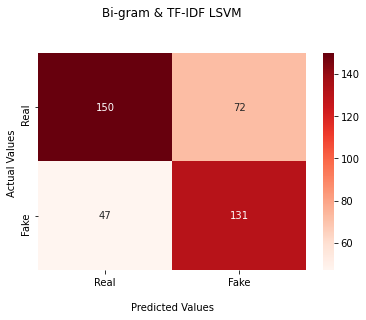

In [0]:
# Code Contribution Daud

predictionAndLabels_lsvm_classD = prediction_lsvm_classD.select(col("label"), col("prediction"))

metrics_lsvm_classD = MulticlassMetrics(predictionAndLabels_lsvm_classD.rdd.map(tuple))

classD_lsvm_metrics = metrics_lsvm_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

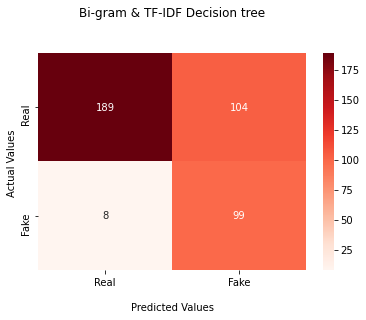

In [0]:
# Code Contribution Daud

predictionAndLabels_dt_classD = prediction_dt_classD.select(col("label"), col("prediction"))

metrics_dt_classD = MulticlassMetrics(predictionAndLabels_dt_classD.rdd.map(tuple))

classD_dt_metrics = metrics_dt_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF Decision tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Extended Data ML

In [0]:
# Code Contribution Daud

X = data_extended.select("Text")
y = data_extended.select("Category")

In [0]:
# Code Contribution Daud

# Spliting the data into a 80-20 train test split

X_train, X_test = X.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(X_train.count()))
print("Test Dataset Count: " + str(X_test.count()))

Training Dataset Count: 2394
Test Dataset Count: 606


In [0]:
# Code Contribution Daud
(y_train, y_test) = y.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(y_train.count()))
print("Test Dataset Count: " + str(y_test.count()))

Training Dataset Count: 2394
Test Dataset Count: 606


In [0]:
# Code Contribution Daud

# since there is no common column between these two dataframes add row_index so that it can be joined
X_train=X_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
y_train=y_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

data_train = X_train.join(y_train, on=["row_index"]).drop("row_index")
data_train.show()

# since there is no common column between these two dataframes add row_index so that it can be joined
X_test=X_test.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
y_test=y_test.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

data_test = X_test.join(y_test, on=["row_index"]).drop("row_index")
data_test.show()

+--------------------+--------+
|                Text|Category|
+--------------------+--------+
|[126, year, endor...|    Fake|
|[14,000, genese, ...|    Fake|
|[14,000, genese, ...|    Fake|
|[18, octob, 2016,...|    Fake|
|[1988, democrat, ...|    Fake|
|[2013, north, car...|    Fake|
|[2016, presidenti...|    Fake|
|[28, day, left, g...|    Fake|
|[74, year, old, w...|    Fake|
|[aboard, air, for...|    Fake|
|[aboard, air, for...|    Fake|
|[aboard, air, for...|    Fake|
|[accord, donald, ...|    Fake|
|[actor, morgan, f...|    Fake|
|[ad, disgust, man...|    Fake|
|[add, one, name, ...|    Fake|
|[aftermath, great...|    Fake|
|[ah, simpson, hil...|    Fake|
|[albani, new, yor...|    Fake|
|[albani, new, yor...|    Fake|
+--------------------+--------+
only showing top 20 rows

+--------------------+--------+
|                Text|Category|
+--------------------+--------+
|[50, call, republ...|    Fake|
|[aboard, air, for...|    Fake|
|[actress, helen, ...|    Fake|
|[addict, info

# UniGram with TF

In [0]:
# Code Contribution Daud

ngrams = NGram(n = 1, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
 
assembler = VectorAssembler(inputCols = ["TF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Fake is 1, Real is 0


pipeline_lr = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lr])

pipeline_lsvm = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lsvm])

pipeline_dt = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, dt])


paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()
  


crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5) 


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()

crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)

/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)


# UniGram with TF Results

In [0]:
# Code Contribution Daud

prediction_lr_classA = cvModel_lr.transform(data_test)
prediction_lsvm_classA = cvModel_lsvm.transform(data_test)
prediction_dt_classA = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''
    
paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)  

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6588954070082855
[1000, 0.1]
0.6434205043177703
[1000, 0.01]
0.6747978470025117
[5000, 0.1]
0.6675875300332661
[5000, 0.01]
0.6669681091522451
[10000, 0.1]
0.6705128145715455
[10000, 0.01]



LSVM Grid Search Results: 
0.6647342679739866
[1000, 0.1]
0.6582335682630227
[1000, 0.01]
0.6629646930384226
[5000, 0.1]
0.6677310711997488
[5000, 0.01]
0.6745043327724907
[10000, 0.1]
0.670964071823638
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6760976344383031
[1000, 2]
0.6775606963713336
[1000, 3]
0.6795498854026534
[5000, 2]
0.6850509638828288
[5000, 3]
0.6795498854026534
[10000, 2]
0.6850509638828288
[10000, 3]





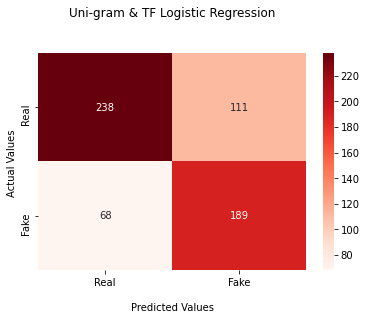

In [0]:
# Code Contribution Daud

predictionAndLabels_lr_classA = prediction_lr_classA.select(col("label"), col("prediction"))

metrics_lr_classA = MulticlassMetrics(predictionAndLabels_lr_classA.rdd.map(tuple))

classA_lr_metrics = metrics_lr_classA.confusionMatrix().toArray()

ax = sns.heatmap(classA_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


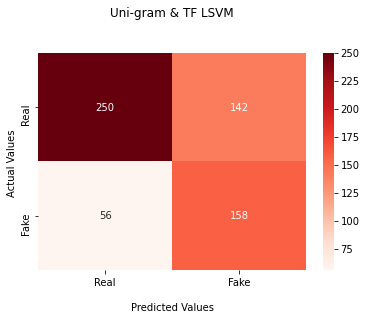

In [0]:
# Code Contribution Daud

predictionAndLabels_lsvm_classA = prediction_lsvm_classA.select(col("label"), col("prediction"))

metrics_lsvm_classA = MulticlassMetrics(predictionAndLabels_lsvm_classA.rdd.map(tuple))

classA_lsvm_metrics = metrics_lsvm_classA.confusionMatrix().toArray()

ax = sns.heatmap(classA_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

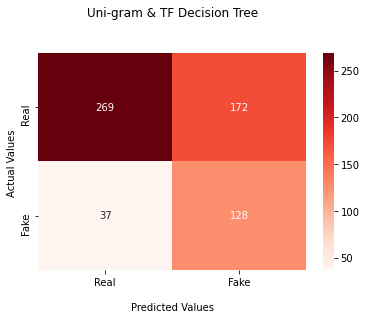

In [0]:
# Code Contribution Daud

predictionAndLabels_dt_classA = prediction_dt_classA.select(col("label"), col("prediction"))

metrics_dt_classA = MulticlassMetrics(predictionAndLabels_dt_classA.rdd.map(tuple))

classA_dt_metrics = metrics_dt_classA.confusionMatrix().toArray()

ax = sns.heatmap(classA_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF Decision Tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Unigram with TF-IDF

In [0]:
# Code Contribution Hamza

ngrams = NGram(n = 1, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
  
idf = IDF(inputCol="TF", outputCol="TFIDF")
 
assembler = VectorAssembler(inputCols = ["TFIDF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lr])
pipeline_lsvm = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lsvm])
pipeline_dt = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, dt])

# removed 10000, 1000
# removed 0.5 and 0.01
paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.5, 0.1]) \
    .build()



crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName='accuracy'),
                          numFolds = 5)  


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()


crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(metricName='accuracy'),
                          numFolds = 5)  


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()


crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(metricName='accuracy'),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)


# Unigram with TF-IDF Results

In [0]:
# Code Contribution Hamza

prediction_lr_classB = cvModel_lr.transform(data_test)
prediction_lsvm_classB = cvModel_lsvm.transform(data_test)
prediction_dt_classB = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6654639380942355
[1000, 0.5]
0.6601817188582184
[1000, 0.1]
0.6778257795463929
[5000, 0.5]
0.6749447888856253
[5000, 0.1]
0.6711494283734728
[10000, 0.5]
0.6670011297433116
[10000, 0.1]



LSVM Grid Search Results: 
0.6701218075472561
[1000, 0.1]
0.6664641013135
[1000, 0.01]
0.6672269254783803
[5000, 0.1]
0.6706280547359482
[5000, 0.01]
0.6739087884335461
[10000, 0.1]
0.6730218794586762
[10000, 0.01]



Decision Tree Grid Search Results: 
0.691655989096486
[1000, 2]
0.6888310256494842
[1000, 5]
0.6958078461406721
[5000, 2]
0.7007146397216117
[5000, 5]
0.6958078461406721
[10000, 2]
0.7007146397216117
[10000, 5]





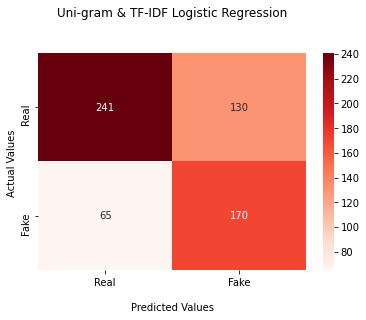

In [0]:
# Code Contribution Hamza

predictionAndLabels_lr_classB = prediction_lr_classB.select(col("label"), col("prediction"))

metrics_lr_classB = MulticlassMetrics(predictionAndLabels_lr_classB.rdd.map(tuple))

classB_lr_metrics = metrics_lr_classB.confusionMatrix().toArray()

ax = sns.heatmap(classB_lr_metrics, annot=True, cmap='Reds', fmt='.0f')
#sns.heatmap(table1, cmap='Purples', fmt='.4f')


ax.set_title('Uni-gram & TF-IDF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


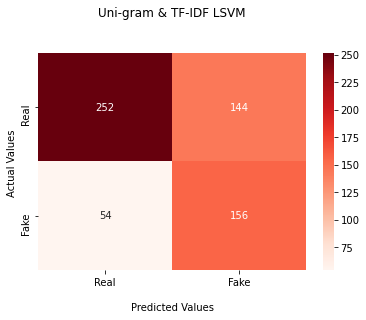

In [0]:
# Code Contribution Hamza

predictionAndLabels_lsvm_classB = prediction_lsvm_classB.select(col("label"), col("prediction"))

metrics_lsvm_classB = MulticlassMetrics(predictionAndLabels_lsvm_classB.rdd.map(tuple))

classB_lsvm_metrics = metrics_lsvm_classB.confusionMatrix().toArray()

ax = sns.heatmap(classB_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF-IDF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

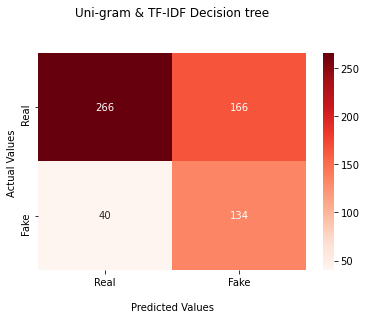

In [0]:
# Code Contribution Hamza

predictionAndLabels_dt_classB = prediction_dt_classB.select(col("label"), col("prediction"))

metrics_dt_classB = MulticlassMetrics(predictionAndLabels_dt_classB.rdd.map(tuple))

classB_dt_metrics = metrics_dt_classB.confusionMatrix().toArray()


ax = sns.heatmap(classB_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Uni-gram & TF-IDF Decision tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [0]:
# ON DEC 11 4 AM, COMPLETED RUNS TILL HERE

# Bigram with TF

In [0]:
# Code Contribution Daud

ngrams = NGram(n = 2, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
 
assembler = VectorAssembler(inputCols = ["TF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lr])
pipeline_lsvm = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, lsvm])
pipeline_dt = Pipeline(stages = [ngrams, cv,  assembler,  label_stringIdx, dt])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()



crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()



crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)

/databricks/spark/python/pyspark/ml/util.py:834: UserWarning: MLflow auto-tracking of MLlib tuning is currently disabled.  To enable this feature, set the flag via `spark.conf.set('spark.databricks.mlflow.trackMLlib.enabled', 'true')` where `spark` is your SparkSession.
  warnings.warn(_MLflowInstrumentation._MLFLOW_TRACKING_DISABLED_MESSAGE)


# Bigram with TF Results

In [0]:
# Code Contribution Daud

prediction_lr_classC = cvModel_lr.transform(data_test)
prediction_lsvm_classC = cvModel_lsvm.transform(data_test)
prediction_dt_classC = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6897965264934687
[1000, 0.1]
0.67965625857496
[1000, 0.01]
0.6967066550191927
[5000, 0.1]
0.6900324632499713
[5000, 0.01]
0.6952796859861305
[10000, 0.1]
0.6923638941557375
[10000, 0.01]



LSVM Grid Search Results: 
0.6937313199838976
[1000, 0.1]
0.6920737725988626
[1000, 0.01]
0.6975799763357111
[5000, 0.1]
0.6935410071992915
[5000, 0.01]
0.7028586949029566
[10000, 0.1]
0.7017883220467342
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6739694894218791
[1000, 2]
0.6825342177678688
[1000, 5]
0.6717549304131563
[5000, 2]
0.686303787385534
[5000, 5]
0.6717549304131563
[10000, 2]
0.6912597497192454
[10000, 5]





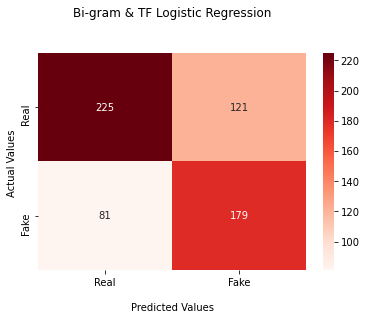

In [0]:
# Code Contribution Daud


predictionAndLabels_lr_classC = prediction_lr_classC.select(col("label"), col("prediction"))

metrics_lr_classC = MulticlassMetrics(predictionAndLabels_lr_classC.rdd.map(tuple))

classC_lr_metrics = metrics_lr_classC.confusionMatrix().toArray()

ax = sns.heatmap(classC_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


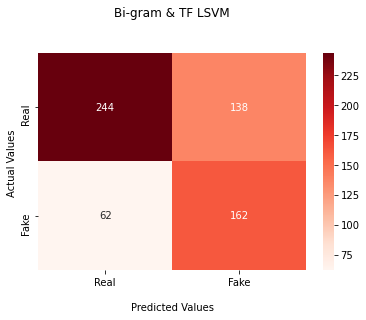

In [0]:
# Code Contribution Daud

predictionAndLabels_lsvm_classC = prediction_lsvm_classC.select(col("label"), col("prediction"))

metrics_lsvm_classC = MulticlassMetrics(predictionAndLabels_lsvm_classC.rdd.map(tuple))

classC_lsvm_metrics = metrics_lsvm_classC.confusionMatrix().toArray()

ax = sns.heatmap(classC_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

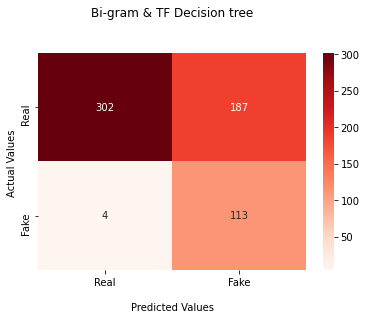

In [0]:
# Code Contribution Daud

predictionAndLabels_dt_classC = prediction_dt_classC.select(col("label"), col("prediction"))

metrics_dt_classC = MulticlassMetrics(predictionAndLabels_dt_classC.rdd.map(tuple))

classC_dt_metrics = metrics_dt_classC.confusionMatrix().toArray()

ax = sns.heatmap(classC_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF Decision tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Bigram with TF-IDF

In [0]:
# Code Contribution Daud

ngrams = NGram(n = 2, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
  
idf = IDF(inputCol="TF", outputCol="TFIDF")
 
assembler = VectorAssembler(inputCols = ["TFIDF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lr])
pipeline_lsvm = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lsvm])
pipeline_dt = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, dt])


paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()



crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5) 


cvModel_lr = crossval_lr.fit(data_train)


paramGrid_lsvm = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(lsvm.regParam, [0.1, 0.01]) \
    .build()


crossval_lsvm = CrossValidator(estimator=pipeline_lsvm,
                          estimatorParamMaps=paramGrid_lsvm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)  


cvModel_lsvm = crossval_lsvm.fit(data_train)


paramGrid_dt = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [1000, 5000, 10000]) \
    .addGrid(dt.maxDepth, [2, 5]) \
    .build()


crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5)


cvModel_dt = crossval_dt.fit(data_train)

# Bigram with TF-IDF Results

In [0]:
# Code Contribution Daud

prediction_lr_classD = cvModel_lr.transform(data_test)
prediction_lsvm_classD = cvModel_lsvm.transform(data_test)
prediction_dt_classD = cvModel_dt.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)
paramGridSearchResults_lsvm = zip(cvModel_lsvm.avgMetrics, paramGrid_lsvm)
paramGridSearchResults_dt = zip(cvModel_dt.avgMetrics, paramGrid_dt)

print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("LSVM Grid Search Results: ")
for item in paramGridSearchResults_lsvm:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  
print("Decision Tree Grid Search Results: ")
for item in paramGridSearchResults_dt:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")

Linear Regression Grid Search Results: 
0.6897965264934687
[1000, 0.1]
0.67965625857496
[1000, 0.01]
0.6967066550191927
[5000, 0.1]
0.6900324632499713
[5000, 0.01]
0.6952796859861305
[10000, 0.1]
0.6923638941557375
[10000, 0.01]



LSVM Grid Search Results: 
0.6945164589687711
[1000, 0.1]
0.6897747269796952
[1000, 0.01]
0.6959828158685344
[5000, 0.1]
0.6977597649173848
[5000, 0.01]
0.7016955526300273
[10000, 0.1]
0.7031834616571428
[10000, 0.01]



Decision Tree Grid Search Results: 
0.6739694894218791
[1000, 2]
0.6825342177678688
[1000, 5]
0.6717549304131563
[5000, 2]
0.686303787385534
[5000, 5]
0.6717549304131563
[10000, 2]
0.6912597497192454
[10000, 5]





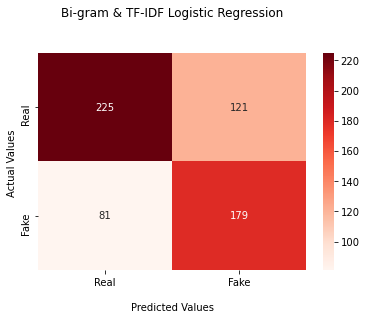

In [0]:
# Code Contribution Daud

predictionAndLabels_lr_classD = prediction_lr_classD.select(col("label"), col("prediction"))

metrics_lr_classD = MulticlassMetrics(predictionAndLabels_lr_classD.rdd.map(tuple))

classD_lr_metrics = metrics_lr_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


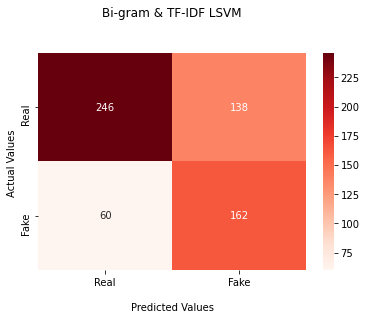

In [0]:
# Code Contribution Daud

predictionAndLabels_lsvm_classD = prediction_lsvm_classD.select(col("label"), col("prediction"))

metrics_lsvm_classD = MulticlassMetrics(predictionAndLabels_lsvm_classD.rdd.map(tuple))

classD_lsvm_metrics = metrics_lsvm_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_lsvm_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF LSVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

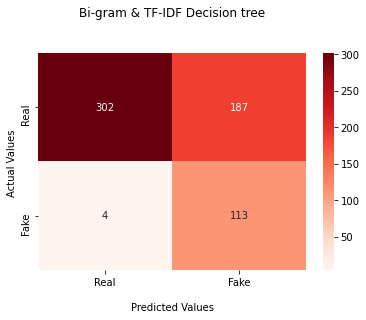

In [0]:
# Code Contribution Daud
predictionAndLabels_dt_classD = prediction_dt_classD.select(col("label"), col("prediction"))

metrics_dt_classD = MulticlassMetrics(predictionAndLabels_dt_classD.rdd.map(tuple))

classD_dt_metrics = metrics_dt_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_dt_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF Decision tree\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Report Result Section F

From out Performance Analysis, the best performing model on the new + old dataset is the Logistic Regresion model using Bi-gram and TF-IDF. It returned an acurracy score of 70%. And so we view and analyse the misclassified records in the prediction.

In [0]:
# Code Contribution Okeoghenemarho

ngrams = NGram(n = 2, inputCol="Text", outputCol="{n}_grams")
  
cv = CountVectorizer(inputCol="{n}_grams" ,outputCol="TF")
  
idf = IDF(inputCol="TF", outputCol="TFIDF")
 
assembler = VectorAssembler(inputCols = ["TFIDF"],outputCol="features") # 
  
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label") # Converts label "fake"/"real" to encoded values of 1 and 0

pipeline_lr = Pipeline(stages = [ngrams, cv, idf,  assembler,  label_stringIdx, lr])


paramGrid_lr = ParamGridBuilder() \
    .addGrid(cv.vocabSize, [10000]) \
    .addGrid(lr.regParam, [0.1]) \
    .build()



crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds = 5) 


cvModel_lr = crossval_lr.fit(data_train)



MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.


In [0]:
# Code Contribution Okeoghenemarho

prediction_lr_classD_test = cvModel_lr.transform(data_test)

'''
cvModel_dt.getEstimatorParamMaps()[ np.argmax(cvModel_dt.avgMetrics) ]
evaluator=MulticlassClassificationEvaluator()
print("Test Accuracy: " + str(evaluator.evaluate(prediction_classA, {evaluator.metricName: "accuracy"})))
'''

paramGridSearchResults_lr = zip(cvModel_lr.avgMetrics, paramGrid_lr)


print("Logistic Regression Grid Search Results: ")
for item in paramGridSearchResults_lr:
  print(item[0])
  print(list(item[1].values()))
print("\n\n")
  

Logistic Regression Grid Search Results: 
0.6952796859861305
[10000, 0.1]





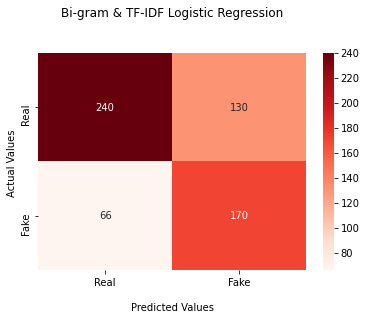

In [0]:
# Code Contribution Okeoghenemarho

predictionAndLabels_lr_classD_test = prediction_lr_classD_test.select(col("label"), col("prediction"))

metrics_lr_classD = MulticlassMetrics(predictionAndLabels_lr_classD_test.rdd.map(tuple))

classD_lr_metrics = metrics_lr_classD.confusionMatrix().toArray()

ax = sns.heatmap(classD_lr_metrics, annot=True, cmap='Reds', fmt='.0f')

ax.set_title('Bi-gram & TF-IDF Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])

## Display the visualization of the Confusion Matrix.
plt.show()


In [0]:
# Code Contribution Okeoghenemarho

mislabeled_data_best_model = prediction_lr_classD_test.select('{n}_grams', 'TFIDF', 'label', 'prediction').filter(col("label") != col("prediction"))
print("Number of Misclassified Records is: " + str(mislabeled_data_best_model.count()))
display(mislabeled_data_best_model)

Number of Misclassified Records is: 196


{n}_grams TFIDF label prediction List(addict info, info report, report donald, donald trump, trump like, like run, run biggest, biggest campaign, campaign scam, scam american, american history.whil, history.whil trump, trump claim, claim self, self fund, fund campaign, campaign major, major candid, candid fund, fund come, come form, form loan, loan trump, trump own, own entiti, entiti rather, rather donations.in, donations.in realiti, realiti trump, trump campaign, campaign owe, owe donald, donald trump, trump ten, ten million, million dollar, dollar claim, claim campaign, campaign expect, expect pay, pay loan, loan back, back recent, recent campaign, campaign file, file fec, fec show, show money, money still, still treat, treat campaign, campaign debt.when, debt.when addict, addict info, info first, first report, report trump, trump self, self fund, fund scam, scam april, april campaign, campaign owe, owe candid, candid 17.5, 17.5 million, million time, time loan, loan campaign, campaign trump, trump account, account 70, 70 percent, percent contribut, contribut received.a, received.a nbc, nbc report, report sinc, sinc campaign, campaign last, last file, file fec, fec amount, amount owe, owe donald, donald trump, trump doubl, doubl exceed, exceed 43, 43 million.in, million.in spite, spite trump, trump assur, assur loan, loan paid, paid back, back invit, invit upcom, upcom fundrais, fundrais obtain, obtain los, los angel, angel time, time publish, publish nbc, nbc news, news rais, rais even, even suspicion, suspicion loans.imag, loans.imag credit, credit los, los angel, angel time, time via, via nbc, nbc newsaccord, newsaccord inform, inform print, print invit, invit first, first 2700, 2700 donat, donat receiv, receiv fundrais, fundrais design, design trump, trump campaign, campaign use, use primari, primari election.nbc, election.nbc news, news verifi, verifi inform, inform print, print invit, invit accurate.sinc, accurate.sinc republican, republican primari, primari elect, elect would, would seem, seem reason, reason continu, continu rais, rais money, money trump, trump primari, primari campaign, campaign pay, pay earlier, earlier campaign, campaign debt, debt own, own candid, candid himself.a, himself.a report, report trump, trump vow, vow first, first presidenti, presidenti candid, candid make, make profit, profit campaign.ther, campaign.ther noth, noth stop, stop trump, trump use, use futur, futur donat, donat pay, pay back, back loan, loan made, made campaign, campaign interest.th, interest.th latest, latest fec, fec file, file along, along detail, detail fundrais, fundrais activ, activ suggest, suggest exact, exact plan, plan do.photo, do.photo joe, joe raedle/getti, raedle/getti imag) Map(vectorType -> sparse, length -> 10000, indices -> List(0, 15, 28, 238, 279, 337, 348, 440, 448, 564, 647, 706, 737, 888, 970, 1054, 1272, 1829, 2037, 2056, 2670, 2864, 3108, 3109, 3241, 5173, 7710, 7970, 8136, 8220, 8717, 9698), values -> List(1.2007784228426983, 1.6741156221027613, 4.511371141426463, 3.4636503963087053, 3.4770734166408457, 3.6067512399493786, 7.441390998597193, 3.703601065939296, 3.7380872420104656, 4.117576863715369, 8.039876788302907, 4.1702205972007915, 4.1976195713889055, 4.1702205972007915, 4.413842679858542, 4.448933999669812, 4.485301643840686, 4.645644293915866, 4.736616072121593, 10.146176617485612, 4.947925165788799, 4.947925165788799, 5.008549787605235, 4.947925165788799, 5.008549787605235, 5.2962318600570155, 5.70169696816518, 5.583913932508796, 5.583913932508796, 5.583913932508796, 5.583913932508796, 5.989379040616961)) 0.0 1.0 List(appal exact, exact surpris, surpris see, see way, way republican, republican respond, respond sudden, sudden death, death suprem, suprem court, court justic, justic antonin, antonin scalia, scalia parti, parti increas, increas defin, defin sole, sole opposit, opposit presid, presid obama, obama immedi, immedi declar, declar would, would allow, allow fulfil, fulfil constitut, c

# End of Notebook